# K-means clustering

In this notebook will contain several tests to help determine the best number of clusters and the number of components that should be used in the pca. First, several functions will be given that can be used to test the different variables. After that, the results will be plotted.

The results of this notebook combined with the findings of other notebooks (e.g. visualization of initial clusters) will be used to determine the number of clusters.

The final clusters will be made in a different notebook.

## Importing data

First, the neccesary modules will be imported and the data will be loaded

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler



In [2]:
project_name = 'Delft'
image_features_folder = r'Data\Delft\image_features'
network_data_path = r'C:\Users\lange\OneDrive\Documenten\Jaar_5-Msc_CE_TTE\DSAIE_STREETS\Data_old\Delft_NL'

name = 'edges_drive'
random_state = 22

In [3]:
with open(r'Data\Delft\edges_drive_vector_assignments.pkl', 'rb') as file:
    section_vectors = pickle.load(file)

network_features = []
for features in section_vectors.values():
    network_features.append(features)
network_features = np.array(network_features)

In [4]:
network_features.shape

(1541, 4096)

In [5]:
def scale_data(features):
    """Scale the data to 0-1 or normalize the data"""
    scaler = MinMaxScaler()
    
    return scaler.fit_transform(features)

# TODO: Rename variance to n_components and provide explanation
def dim_reduction(features, variance, random_state):
    """This function performs the dimensionality reduction"""
    pca = PCA(n_components=variance, svd_solver='full', random_state=random_state)
    pca.fit(features)
    dim_reduced_features = pca.transform(features)

    return dim_reduced_features

def pca_kmeans(features, n_clusters, random_state):
    """This function creates the clusters using kmeans"""

    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(features)

    inertia = kmeans.inertia_
    return kmeans, inertia

def calc_silhouette(features, kmeans_object, sample_size):
    """Calculates the silhouette score based on a certain sample size"""

    if len(set(kmeans_object.labels_)) > 1:
        # Calculatted using euclidean distance
        try:
            score = silhouette_score(features, kmeans_object.labels_, sample_size=sample_size)
        except ValueError:
            score = calc_silhouette(features, kmeans_object, sample_size)
    else:
        score = np.nan

    return score

In [6]:
def iterate_pca_means(features: np.ndarray, iterations: int, variances: list[float], max_clusters: int, silhouette_sample_size: int|None = None):
    """Method to iterate over different cluster numbers, components for the pca and sample sized for the silhouette score.
    For each iteration, differnent random states are used to slightly randomize the process.

    Parameters:
    features: the original (unscaled) features
    iterations: Number of to perform the entire pca_means
    variances: List of amounts of variance to perform clustering with.
    max_clusters: Perform clustering from one up to and including this number of clusters.
    silhouette_sample_size: If not None, calculate silhouette score with this number of samples.

    Returns:
    kmeans_array: 3d numpy array with kmeans objects of all performed clusterings 
                    size: (iterations x len(cluster_list) x len(variance))
    inertia_array: 3d numpy array with inertias of each clustering 
                    size: (iterations x len(cluster_list) x len(variance))
    silhouette_array: 3d numpy array with all silhouette scores 
                    size: (iterations x len(cluster_list) x len(variance))
    components_list: 1d numpy array containing the number of components for each variance
                    size: (len(variance))
    """
    print(f"Starting pca kmeans iteration with {iterations} iterations, with {len(variances)} variances per iteration and {max_clusters} number of clusters per variance")
    features_scaled = scale_data(features) # scale features

    print(f"Getting component list for given variances")
    components_list = []
    for variance in variances:
        dim_reduced_features = dim_reduction(features_scaled, variance, random_state=22) # TODO: What to do with random_state here
        components_list.append(dim_reduced_features.shape[1])
        print(f"\t{dim_reduced_features.shape[1]} components for variance {variance}")

    # Create arrays to store the results
    kmeans_array = np.empty((iterations, len(components_list), max_clusters-1), dtype=object)
    inertia_array = np.zeros((iterations, len(components_list), max_clusters-1))
    silhouette_array = np.zeros((iterations, len(components_list), max_clusters-1))

    # Perform iteration
    for iteration in range(iterations):
        print(f"\nIteration {iteration+1}")

        for var_index, variance in enumerate(variances):
            print(f"\tVariance: {variance}")
            
            # Dimensionality reduction
            dim_reduced_features = dim_reduction(features_scaled, components_list[var_index], random_state=iteration)
            
            for n_clusters in range(2, max_clusters+1):
                # print(f"\t{n_clusters} clusters")
                
                # Clustering
                kmeans_object, inertia = pca_kmeans(dim_reduced_features, n_clusters, random_state=iteration)
                kmeans_array[iteration, var_index, n_clusters-2] = kmeans_object
                inertia_array[iteration, var_index, n_clusters-2] = inertia
                
                # Determing silhouette scores
                score = calc_silhouette(dim_reduced_features, kmeans_object, silhouette_sample_size)
                silhouette_array[iteration, var_index, n_clusters-2] = score


        # # Save results        
        # if pickle_save is True:
        #     pickle.dump(kmeans_array, open( f"pickle_dump\kmeans3.p", "wb" ))
        #     pickle.dump(sse_array, open( f"pickle_dump\sse3.p", "wb" ))
        #     pickle.dump(sil_array, open( f"pickle_dump\sil3.p", "wb" ))

    return kmeans_array, inertia_array, silhouette_array, components_list
    

In [71]:
iterations = 15
variances = [0.8, 0.9, 0.95]
max_clusters = 36

In [72]:
kmeans_array, inertia_array, silhouette_array, n_components = iterate_pca_means(features=network_features, iterations=iterations, variances=variances,
                                                                                max_clusters=max_clusters, silhouette_sample_size=None)

Starting pca kmeans iteration with 15 iterations, with 3 variances per iteration and 36 number of clusters per variance
Getting component list for given variances
	167 components for variance 0.8
	339 components for variance 0.9
	542 components for variance 0.95

Iteration 1
	Variance: 0.8
	Variance: 0.9
	Variance: 0.95

Iteration 2
	Variance: 0.8
	Variance: 0.9
	Variance: 0.95

Iteration 3
	Variance: 0.8
	Variance: 0.9
	Variance: 0.95

Iteration 4
	Variance: 0.8
	Variance: 0.9
	Variance: 0.95

Iteration 5
	Variance: 0.8
	Variance: 0.9
	Variance: 0.95

Iteration 6
	Variance: 0.8
	Variance: 0.9
	Variance: 0.95

Iteration 7
	Variance: 0.8
	Variance: 0.9
	Variance: 0.95

Iteration 8
	Variance: 0.8
	Variance: 0.9
	Variance: 0.95

Iteration 9
	Variance: 0.8
	Variance: 0.9
	Variance: 0.95

Iteration 10
	Variance: 0.8
	Variance: 0.9
	Variance: 0.95

Iteration 11
	Variance: 0.8
	Variance: 0.9
	Variance: 0.95

Iteration 12
	Variance: 0.8
	Variance: 0.9
	Variance: 0.95

Iteration 13
	Variance: 0

In [108]:
def plot_silhouette(silhouette_array, variances, components_list, max_clusters):
    """Plot the silhouette score for the different cluster methods."""

    plt.figure(figsize=(10, 6))

    color_list = np.array([['salmon', 'lightblue', 'lightgreen', 'orange'], 
                   ['firebrick', 'midnightblue', 'darkgreen', 'darkgoldenrod'],
                   ['sienna', 'aqua', 'palegreen', 'gold']])

    for iteration in range(len(inertia_array)):
        for var_index, variance in enumerate(variances):
            if iteration == 0:
                plt.plot([], [], 
                            label=f'{variance * 100:.0f}% variance, {components_list[var_index]} components', 
                            color=color_list[1, var_index])
                
            plt.plot(range(2, max_clusters+1), silhouette_array[iteration, var_index, :], color=color_list[1, var_index], alpha=0.6)

    plt.xlabel('Number of clusters')
    plt.xticks(range(2, max_clusters+1))
    plt.ylabel('Silhouette score')
    
    if np.nanmax(silhouette_array) < 0.17:
        ymax = np.nanmax(silhouette_array)
    else:
        ymax = 0.17

    plt.ylim(np.nanmin(silhouette_array), ymax)
    plt.title(f'Silhouette Score of PCA Kmeans Clustering using {name} Features')
    plt.legend()

A higher silhouette score means that there is less overlap between the clusters

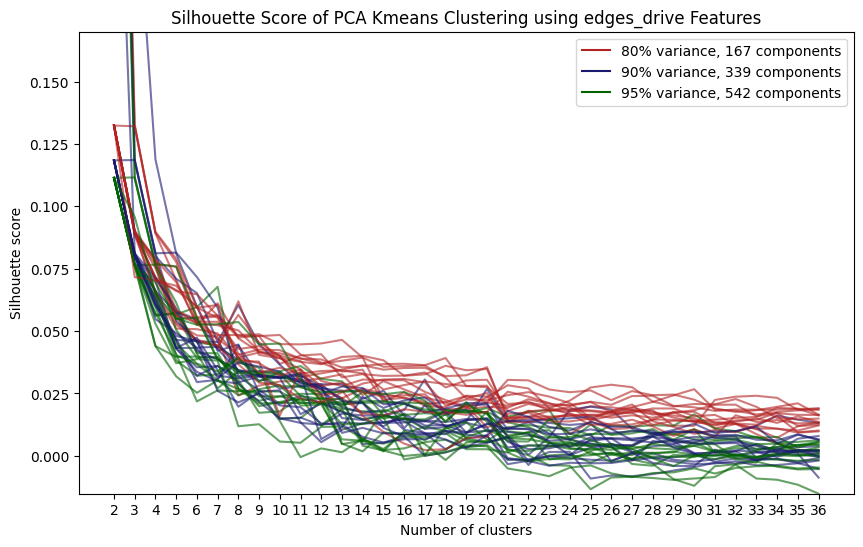

In [109]:
plot_silhouette(silhouette_array, variances=variances, components_list=n_components, max_clusters=max_clusters)

In [110]:
def plot_inertia(inertia_array, variances, components_list, max_clusters):
    """Plot the inertia for the different cluster methods."""

    plt.figure(figsize=(10, 6))

    color_list = np.array([['salmon', 'lightblue', 'lightgreen', 'orange'], 
                   ['firebrick', 'midnightblue', 'darkgreen', 'darkgoldenrod'],
                   ['sienna', 'aqua', 'palegreen', 'gold']])

    for iteration in range(len(inertia_array)):
        for var_index, variance in enumerate(variances):
            if iteration == 0:
                plt.plot([], [], label=f'{variance * 100:.0f}% variance, {components_list[var_index]} components', 
                         color=color_list[1, var_index])
            
            plt.plot(range(2, max_clusters+1), inertia_array[iteration, var_index, :], color=color_list[1, var_index], alpha=0.6)

    plt.xlabel('Number of clusters')
    plt.xticks(range(2, max_clusters+1))
    plt.ylabel('Inertia')
    plt.title(f'PCA KMeans Clustering Inertia of {name} Features')
    plt.legend()

A lower inertia means that the data points lay closer to the cluster centers

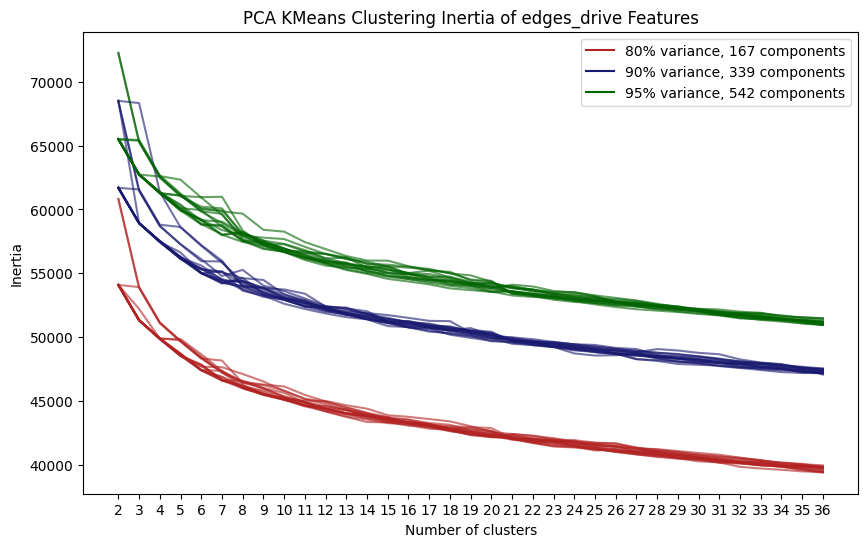

In [111]:
plot_inertia(inertia_array, variances=variances, components_list=n_components, max_clusters=max_clusters)

In [112]:
def determine_elbow_point(inertia_array: np.ndarray, variance: int, max_clusters: int, factor: float=1, plot: bool=False):

    cluster_estimate = 0
    cluster_estimate_2 = 0
    report = {}

    for iteration in range(len(inertia_array)):
        log_delta_first = np.log(np.abs(inertia_array[iteration, variance, 1] - inertia_array[iteration, variance, 0]))
        log_delta_last = np.log(np.abs(inertia_array[iteration, variance, max_clusters-2] - inertia_array[iteration, variance, max_clusters-3]))
        #print(log_delta_first, log_delta_last)

        for n_clusters in range(max_clusters-2):
            log_delta_n = np.log(np.abs(inertia_array[iteration, variance, n_clusters+2] - inertia_array[iteration, variance, n_clusters+1]))
            #print(log_delta_n)

            if abs(log_delta_last - log_delta_n) < abs(log_delta_n - log_delta_first) * factor:
                cluster_estimate += (n_clusters+2) * (1 / len(inertia_array))

                for n2_clusters in range(n_clusters, max_clusters-2):
                    log_delta_n_2 = np.log(np.abs(inertia_array[iteration, variance, n2_clusters+2] - inertia_array[iteration, variance, n2_clusters+1]))
                    #print(log_delta_n)

                    if abs(log_delta_last - log_delta_n_2) < abs(log_delta_n_2 - log_delta_n) * factor:
                        cluster_estimate_2 += (n2_clusters+2) * (1 / len(inertia_array))
                        report[iteration] = (n_clusters+2, n2_clusters+2)
                        break

                break
    
    if plot:
        plot_inertia(inertia_array, variances=[variances[variance]], components_list=n_components, max_clusters=max_clusters)
        y_min = np.min(inertia_array[:, variance, :])
        y_max = np.max(inertia_array[:, variance, :])
        plt.vlines([cluster_estimate], ymin=y_min, ymax=y_max, label=f"Middlepoint Elbow ({cluster_estimate:.3f})")
        plt.vlines([cluster_estimate_2], ymin=y_min, ymax=y_max, label=f"Endpoint Elbow ({cluster_estimate_2:.3f})")
        plt.legend()
    
    print(f"For the middle elbow point the optimal number of clusters is {cluster_estimate:.3f}")
    print(f"For the end elbow point the optimal number of clusters is {cluster_estimate_2:.3f}")

For the middle elbow point the optimal number of clusters is 6.533
For the end elbow point the optimal number of clusters is 11.133


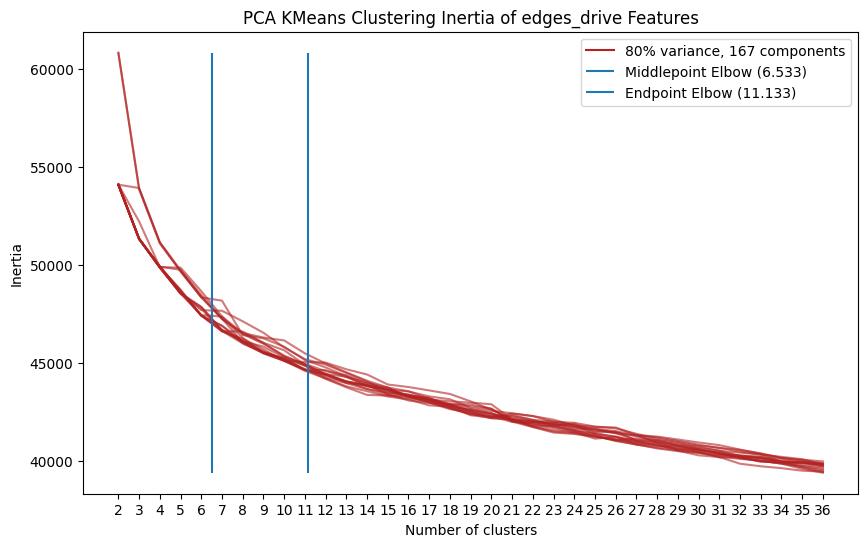

: 

In [113]:
determine_elbow_point(inertia_array=inertia_array, variance=0, max_clusters=max_clusters, plot=True)

Based on these graphs it is clear that there is not one perfect cluster size or number of components. 

In these graphs 3 scenarios were tested for the number of components in the pca, based on the percentage of variance that would be kept after the dimensionality reduction: 80, 90 and 95%. Both the plots for the silhouette score and the inertia have similar behaviour, so it does not seem that the behaviour of the data fundamentally changes after the dimensionality reduction. At the end, it was chosen to keep the the scenario where 80% of the variance is kept. This is done because it still a significant part of the variance stays intact, but the number of components stays at a manageable level. When increasing the variance from 80 to 90%, the number of components doubles and when going to a variance of 95% the number of components doubles again.

**80% variance** seemed to be a good compromis between detail and computation time.

Secondly, the number of clusters. Two statistics were used to help determine the number of clusters. The silhouette score ranges between -1 and 1 and is a measure of and assesses how well a datapoint fits in is own cluster and how distinct it is from different clusters. A higher silhouette score means that the clusters are more distinct (https://www.educative.io/answers/what-is-silhouette-score).
As seen in the graphs, the silhouette score is the highest in the case with only 2 clusters and decreases quickly after that. This indicates that there are no very clear clusters that can be identified and that the clusters have overlap to some extent. The largest decrease in silhouette score is between 2 and 9 clusters, with a small less steep decrease around 5 clusters. 
To conclude, according to the silhouette score, the number of clusters should be as low as possible, preferably under 9 clusters to keep the clusters as distinct as possible. 

The second statistic is the intertia. The inertia is calculated by measuring the squared distance from each data point to the centroid of each cluster and summing it. A lower intertia means that the data is better clustered. Because the inertia will be the lowest with as many clusters as data points, there is a trade off between number of clusters and the inertia. The optimal number of clusters can be found using the "elbow method". This is the point where the decrease in inertia begins to slow (https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet).
The elbow in the graphs above is not one very clear point. Somewhere between 5 and 12 clusters, the decrease in inertia becomes less steep and continues with a linear decrease. 

At the end a cluster size of **7 clusters** is chosen for all network types. This seemed like a good compromis between a low inertia around the 'elbow' and a not too low silhouette score. 

In different notebooks, more cluster methods are used besides kmeans clustering. To simplify and to make the different clusters and network types more comparable with each other, the number of components with 80% variance and a cluster size of 7 clusters will be used for all methods. 